In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

from analytic_wfm.peakdetect import *

%run "Fonctions.ipynb"

In [2]:
final_df = pd.DataFrame()
files = find_all_extension('../Millau/Resultats/', '.txt')
for elt in files:
    final_df = pd.concat([final_df, recover_sig(elt, ['A07'])], axis=1)

In [3]:
test = []
for elt in final_df.columns:
    if 'time' in elt:
        test.append(elt)
        
final_df[test].isnull().sum()[final_df[test].isnull().sum() == 0].index[0]

'time_20170620143533742'

In [ ]:
2017-06-20-00-03-34-150
2017-06-20-00-03-41-144
2017-06-20-00-05-50-623
2017-06-20-00-05-57-142
2017-06-20-00-08-22-224
2017-06-20-00-33-07-871
2017-06-20-00-38-57-400
2017-06-20-00-39-22-968
2017-06-20-00-41-37-410
2017-06-20-00-45-20-611
2017-06-20-00-52-24-732
2017-06-20-00-54-50-955
2017-06-20-00-56-40-892
2017-06-20-00-57-12-093
2017-06-20-00-59-34-488

In [179]:
siwim_sig = list_multiple_var('A0', var_to=9) + list_multiple_var('A', 10, 21)

In [180]:
# Récupération des signaux
signaux = recover_sig('../Millau/Resultats\\2017-06-20-hh-mm-ss\\2017-06-20-00-mm-ss\\2017-06-20-00-33-07-871.txt', siwim_sig)

# Somme des signaux
signaux = somme_signaux(signaux)

# Supperposition des signaux
signaux = supperposition_signaux(signaux, 10)

# Création de la zone à supprimer
fourchette = signaux.iloc[:int((41/100)*len(signaux)),:].iloc[:,1].std()*3

# Calcul et nettoyage des pics
pics = calcul_pics(signaux, 40, 0.7, fourchette)[0]

In [181]:
min1 = min_max_separation(pics)[0][min_max_separation(pics)[0]['Amplitude'] < fourchette].reset_index(drop=True)
max2 = min_max_separation(pics)[1]

In [182]:
middle_amplitude = max2[['Amplitude']]/2
middle_position = min1[['Time']] + (max2[['Time']]-min1[['Time']])/2

In [183]:
middle = pd.concat([middle_position, middle_amplitude], axis=1)

In [184]:
middle

,Time,Amplitude
0,2.398435,2.902896
1,2.657225,2.888178
2,2.960940,2.535082


In [185]:
def close_point(pic_point, signal):
    diff_ampl = abs(pic_point['Amplitude'] - signal['Sum'])
    diff_time = abs(pic_point['Time'] - signal['Time'])
    
    sum_diff = diff_ampl + diff_time
    id_min = (sum_diff).idxmin()
    
    return signal.iloc[id_min,:]

In [242]:
def next_close_point(pic_point, signal):
    diff_ampl = abs(pic_point['Amplitude'] - signal['Sum'])
    diff_time = abs(pic_point['Time'] - signal['Time'])
    
    truc = pd.concat([diff_ampl, diff_time], axis=1).sort_values(by=["Sum"])
    truc = truc[(truc["Time"] > 0.05) & (truc["Time"] < 0.2) & (truc["Sum"] > 0.007)].iloc[0:5,:]
    print(truc.iloc[0:5,:])
    print(signal.iloc[truc.iloc[:5,:].index,:])
    
    return signal.iloc[truc.index,:]

In [243]:
test = pd.DataFrame()
for index, row in middle.iterrows():
    test = pd.concat([test, pd.DataFrame(next_close_point(row, signaux)).T])
    #print(close_point(row, signaux))

           Sum      Time
1277  0.031382  0.095705
1316  0.048387  0.171875
1315  0.090025  0.169925
1276  0.093790  0.093755
1278  0.143982  0.097655
         Time       Sum
1277  2.49414  2.871514
1316  2.57031  2.951283
1315  2.56836  2.812871
1276  2.49219  2.996686
1278  2.49609  2.758914
           Sum      Time
1277  0.016664  0.163085
1316  0.063105  0.086915
1444  0.070930  0.163085
1315  0.075307  0.088865
1276  0.108508  0.165035
         Time       Sum
1277  2.49414  2.871514
1316  2.57031  2.951283
1444  2.82031  2.817248
1315  2.56836  2.812871
1276  2.49219  2.996686
           Sum     Time
1443  0.093930  0.14258
1442  0.097187  0.14453
1444  0.282166  0.14063
1441  0.288184  0.14649
1445  0.464387  0.13867
         Time       Sum
1443  2.81836  2.629012
1442  2.81641  2.437895
1444  2.82031  2.817248
1441  2.81445  2.246898
1445  2.82227  2.999469


In [235]:
test

,Time,Sum
1235,2.41211,2.895647
1277,2.49414,2.871514
1506,2.94141,2.593590


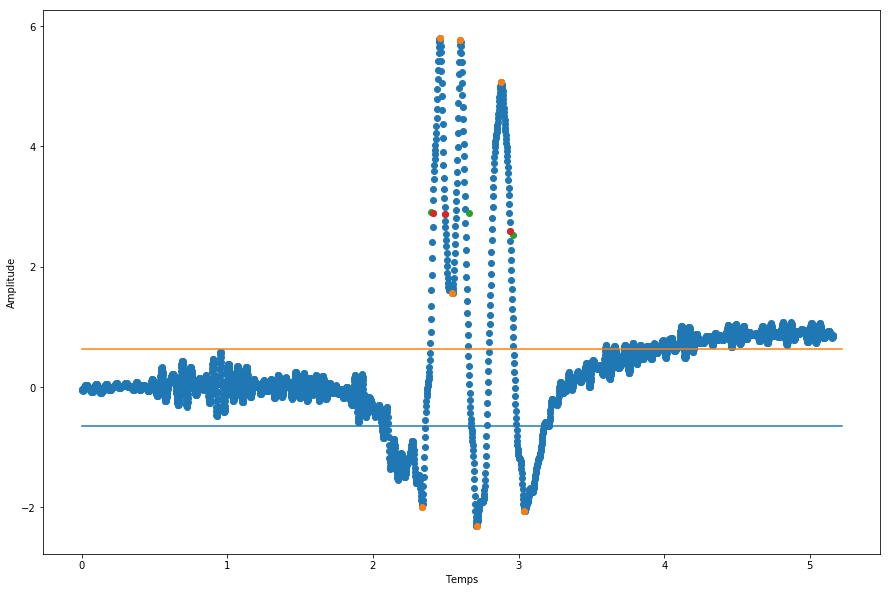

In [236]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.scatter(signaux.iloc[:,0], signaux.iloc[:, 1])

# Detections des maximas et minimas
plt.scatter(pics[0], pics[1])
plt.scatter(middle.iloc[:,0], middle.iloc[:,1])
plt.scatter(test.iloc[:,0], test.iloc[:,1])

plt.plot([0, 5.22], [-fourchette, -fourchette])
plt.plot([0, 5.22], [fourchette, fourchette])

#plt.legend(['A07', 'A09','A12'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

#### Selection meilleur signal

In [301]:
signaux = supperposition_signaux(test)
pics = calcul_pics(signaux, 6, 0.05, 0.15)
best = best_courbe(signaux, pics)

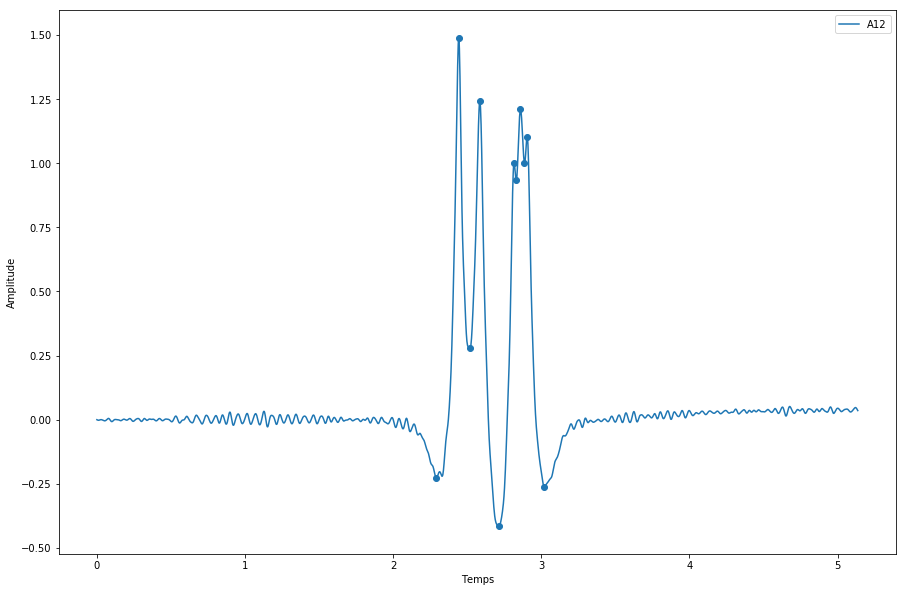

In [302]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(best[0].iloc[:, 0], best[0].iloc[:, 1])

# Detections des maximas et minimas
plt.scatter(best[1].iloc[:, 0], best[1].iloc[:, 1])

plt.legend([best[0].iloc[:,1].name])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()

In [348]:
var_name = ['pos_min_', 'min_', 'pos_max_', 'max_']
var_list = []

for elt in var_name:
    if elt == var_name[0] or elt == var_name[1]:
        var_list.append(list_multiple_var(elt, 1, len(min_sig)))
    else:
        var_list.append(list_multiple_var(elt, 1, len(max_sig)))

In [361]:
pos_min = min_sig[[0]].T.reset_index(drop=True)
min_ampl = min_sig[[1]].T.reset_index(drop=True)
pos_max = max_sig[[0]].T.reset_index(drop=True)
max_ampl = max_sig[[1]].T.reset_index(drop=True)

pos_min.columns = var_list[0]
min_ampl.columns = var_list[1]
pos_max.columns = var_list[2]
max_ampl.columns = var_list[3]

In [371]:
pd.concat([,pos_min, min_ampl, pos_max, max_ampl], axis=1)

,pos_min_1,pos_min_2,pos_min_3,pos_min_4,pos_min_5,pos_min_6,min_1,min_2,min_3,min_4,...,pos_max_1,pos_max_2,pos_max_3,pos_max_4,pos_max_5,max_1,max_2,max_3,max_4,max_5
0,2.29102,2.51758,2.71289,2.83203,2.88672,3.02148,-0.22869,0.27787,-0.41501,0.9331,...,2.44336,2.58594,2.81641,2.85938,2.9043,1.48871,1.24161,1.00157,1.20993,1.10396


#### Somme signaux

In [285]:
test3['time'] = test.iloc[:,0]
test3['sig'] = test.iloc[:,1] + test.iloc[:,2] + test.iloc[:,3]

In [286]:
points = peakdetect(test3.iloc[:, 1],test3.iloc[:, 0], lookahead=5, delta=0.04)

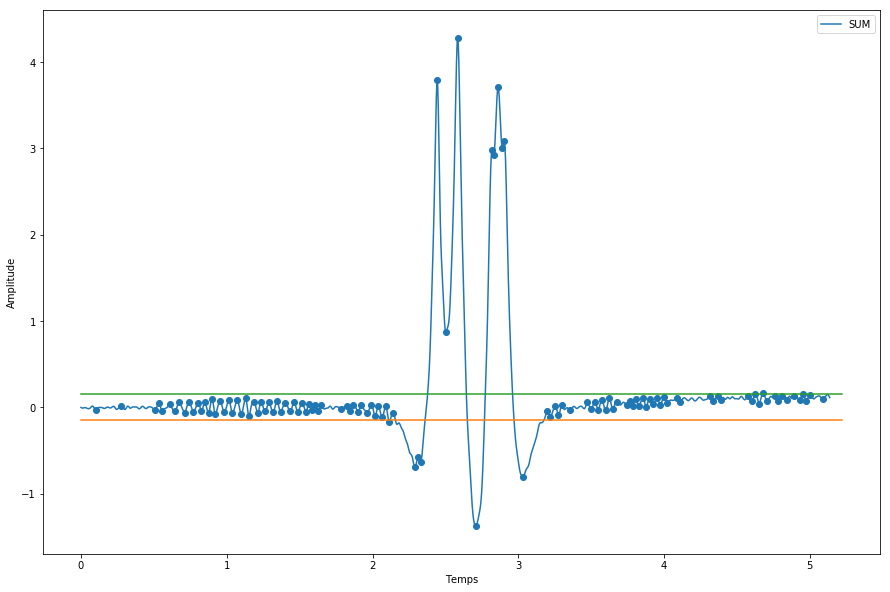

In [287]:
plt.figure(figsize=(15, 10))

# Courbe de capteurs
plt.plot(test3.iloc[:,0], test3.iloc[:, 1])

fourchette = 0.15
plt.plot([0, 5.22], [-fourchette, -fourchette])
plt.plot([0, 5.22], [fourchette, fourchette])

# Detections des maximas et minimas
plt.scatter(np.array(points[0] + points[1]).T[0], np.array(points[0] + points[1]).T[1])

plt.legend(['SUM'])
plt.xlabel("Temps")
plt.ylabel("Amplitude")

plt.show()